In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from star_flow import FlowMatchingModel 

In [2]:
model_path = '/n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG/checkpoints/best-model-epoch=95-val_loss=0.000676.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FlowMatchingModel.load_from_checkpoint(model_path,map_location=device)
model.eval()
model.to(device)
print(f"Loaded model from {model_path}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG/checkpoints/best-model-epoch=95-val_loss=0.000676.ckpt


In [11]:
def predict_star_map(total_mass_map, mass_condtion, num_steps=100):

    # Convert to tensor: (1, 1, H, W)
    input_tensor = torch.FloatTensor(total_mass_map).unsqueeze(0).unsqueeze(0).to(device)
    condition = torch.FloatTensor(mass_condtion).unsqueeze(0).unsqueeze(0).to(device)

    # Generate star map
    with torch.no_grad():
        output = model.sample(input_tensor, condition, num_steps=num_steps)
    
    # Convert back to numpy and denormalize
    star_map = output.cpu().numpy()[0, 0]

    
    return star_map

In [12]:
total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')
star_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy')

tot = np.log1p(total_mass_maps)
star = np.log1p(star_maps)
tot_mean,tot_std = tot.mean(), tot.std()
star_mean,star_std = star.mean(), star.std()

data_stats = {
    'tot_mean': tot_mean,
    'tot_std': tot_std,
    'star_mean': star_mean,
    'star_std': star_std
}

sample_tot = np.log1p(total_mass_maps[0])

sample_tot = (sample_tot - data_stats['tot_mean'])/data_stats['tot_std']

pred_star = predict_star_map(sample_tot, sample_tot, num_steps=300)
true_star = (np.log1p(star_maps[0]) - data_stats['star_mean'])/data_stats['star_std']

In [16]:
model_path = '/n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG0.2/checkpoints/best-model-epoch=53-val_loss=0.021218.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FlowMatchingModel.load_from_checkpoint(model_path,map_location=device)
model.eval()
model.to(device)
print(f"Loaded model from {model_path}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG0.2/checkpoints/best-model-epoch=53-val_loss=0.021218.ckpt


In [17]:
noisy_tot = [sample_tot + np.random.normal(loc=0,scale=0.2,size=(256,256)) for i in range(3)]

noisy_pred = [predict_star_map(noisy, cond, num_steps=300) for noisy, cond in zip(noisy_tot,[sample_tot for i in range(5)])]

In [13]:
import Pk_library as PKL

# parameters
BoxSize = 25.0    
MAS     = 'None'  
threads = 1       


# compute the Pk of that delta
Pk2D_pred = PKL.Pk_plane(pred_star, BoxSize, MAS, threads)

Pk2D_true = PKL.Pk_plane(true_star, BoxSize, MAS, threads)

k_pred      = Pk2D_pred.k   
Pk_pred     = Pk2D_pred.Pk    

k_true      = Pk2D_true.k   
Pk_true     = Pk2D_true.Pk


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


In [18]:
import Pk_library as PKL

noisy_star = np.asarray(noisy_pred)

def get_pk(mat):
    BoxSize = 25.0    
    MAS     = 'None'  
    threads = 1       
    pk = PKL.Pk_plane(mat,BoxSize,MAS,threads,verbose=False)
    return pk.k, pk.Pk

k_pred_star, Pk_pred_star = get_pk(pred_star)
noisy_star_pk = [get_pk(mat) for mat in noisy_star]

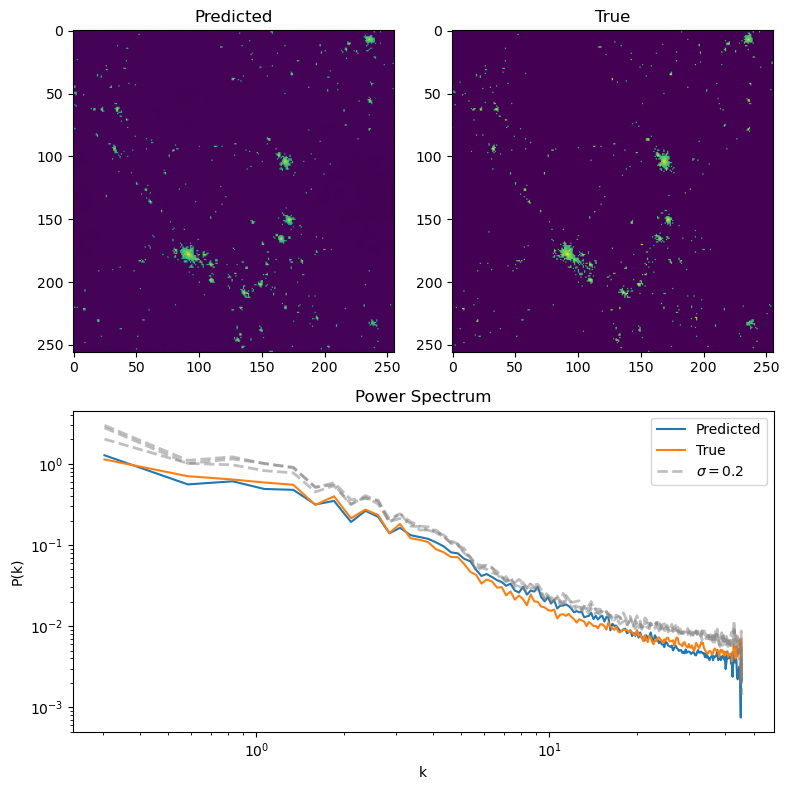

In [19]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Create 2x2 layout with custom height/width
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Top row: image plots
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Predicted")
ax1.imshow(pred_star)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("True")
ax2.imshow(true_star)

# Bottom row: merged plot across both columns
ax3 = fig.add_subplot(gs[1, :])  # spans both columns
ax3.set_title("Power Spectrum")
ax3.loglog(k_pred, Pk_pred, label="Predicted")
ax3.loglog(k_true, Pk_true, label="True")

for i, (k, pk) in enumerate(noisy_star_pk):
    label = r'$\sigma=0.2$' if i == 0 else None  # avoid duplicate labels
    ax3.loglog(k, pk, linewidth=2, alpha=0.5, ls='--', color='gray', label=label)
    
ax3.legend()
ax3.set_xlabel("k")
ax3.set_ylabel("P(k)")

plt.tight_layout()
plt.savefig("sample.png")
plt.show()